In [231]:
import igraph as ig
import networkx as nx
import numpy as np
import polars as pl
import pickle
from collections import defaultdict
from scipy import sparse

from matplotlib import pyplot as plt

import network_conversion as ntc
import graph_importer as gim

In [3]:
# example error pair
pair = np.array([157,   3])

In [5]:
ordering = ntc.Ordering.from_file("./concordant_networks/size_14.csv")

In [8]:
snaps = ntc.SnapshotWithHomeConverter.from_directory(
    "./conc_tempo_14_detailed/",
    ordering=ordering,
)

/home/davidwu/REPOS/echidna_network/network_conversion.py:290: RuntimeWarning: invalid value encountered in divide
  Dp = D / Sig
/home/davidwu/REPOS/echidna_network/network_conversion.py:291: RuntimeWarning: invalid value encountered in divide
  Up = U / Sig


In [43]:
in_mat = np.concatenate([x[np.newaxis, :, :] for x in snaps.inwards_weighting_matrices])

In [47]:
tempo = gim.make_graph("./concordant_networks/temponet_14_365.lgl")

In [272]:
vv0 = tempo.vs.select(loc_eq=ordering.hospitals[157], time_eq=0)[0]
vv1 = tempo.vs.select(loc_eq=ordering.hospitals[3])

vv0, vv1

(igraph.Vertex(<igraph.Graph object at 0x7677b15c2040>, 48808, {'name': '(4691,0)', 'loc': 4691, 'time': 0}),
 <igraph.seq.VertexSeq at 0x76775b7f7560>)

In [66]:
tempo.es['distance'] = [1.0/w for w in tempo.es['weight']]

In [273]:
weakest_link = [min(tempo.es[edges]['weight']) 
                for edges in tempo.get_shortest_paths(
                    vv0, vv1, 
                    weights='distance', 
                    output='epath'
                )]
weakest_link

[1.0,
 3.0,
 2.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 1.0,
 4.0,
 2.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 1.0,
 3.0,
 2.0,
 1.0,
 2.0,
 2.0,
 1.0,
 2.0,
 1.0,
 2.0,
 2.0,
 2.0,
 1.0,
 2.0,
 2.0,
 1.0,
 1.0,
 2.0,
 1.0,
 2.0,
 3.0,
 2.0,
 2.0,
 2.0,
 2.0,
 1.0,
 1.0,
 1.0,
 2.0,
 2.0,
 2.0,
 1.0,
 2.0,
 1.0,
 1.0,
 2.0,
 2.0,
 2.0,
 1.0,
 1.0,
 2.0,
 2.0,
 2.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 1.0,
 2.0,
 2.0,
 1.0,
 1.0,
 2.0,
 1.0,
 1.0,
 1.0,
 2.0,
 2.0,
 2.0,
 1.0,
 2.0,
 2.0,
 2.0,
 1.0,
 2.0,
 2.0,
 2.0,
 1.0,
 1.0,
 2.0,
 1.0,
 1.0,
 2.0,
 2.0,
 2.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 2.0,
 2.0,
 1.0,
 2.0,
 2.0,
 2.0,
 1.0,
 1.0,
 3.0,
 4.0,
 3.0,
 3.0,
 1.0,
 3.0,
 2.0,
 1.0,
 3.0,
 1.0,
 2.0,
 1.0,
 2.0,
 2.0,
 1.0,
 2.0,
 2.0,
 2.0,
 1.0,
 2.0,
 1.0,
 1.0,
 2.0,
 1.0,
 2.0,
 2.0,
 2.0,
 1.0,
 1.0,
 2.0,
 1.0,
 2.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 2.0,
 1.0,
 2.0,
 1.0,
 1.0,
 2.0,
 1.0,
 1.0,
 2.0,
 1.0,
 1.0,
 2.0,
 3.0,
 1.0

In [274]:
weakest_edges = [min(tempo.es[edges], key=lambda x:x['weight']) 
                for edges in tempo.get_shortest_paths(
                    vv0, vv1, 
                    weights='distance', 
                    output='epath'
                )]

In [201]:
[(we.source_vertex, we.target_vertex) for we in weakest_edges if we['weight'] > 17.9][0]

(igraph.Vertex(<igraph.Graph object at 0x7677b15c2040>, 26593, {'name': '(7845,518)', 'loc': 7845, 'time': 518}),
 igraph.Vertex(<igraph.Graph object at 0x7677b15c2040>, 19431, {'name': '(4931,518)', 'loc': 4931, 'time': 518}))

Text(0, 0.5, 'smallest weight on the shortest path')

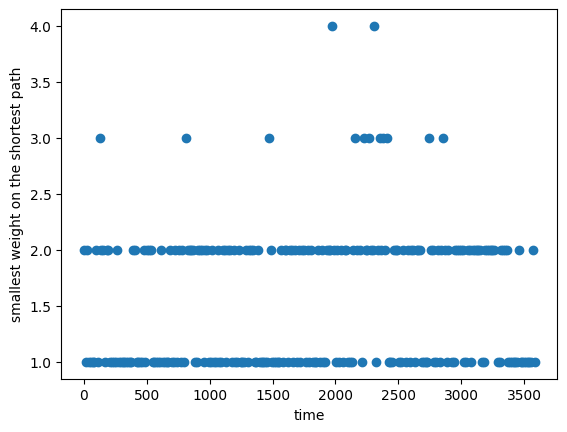

In [275]:
plt.plot(vv1['time'], weakest_link, 'o')

plt.xlabel('time')
plt.ylabel('smallest weight on the shortest path')

In [75]:
snapshots = snaps.load_snapshots("./conc_tempo_14_detailed/")

In [79]:
ss0 = snapshots[0]
ss0.vcount()

296

In [90]:
vvv0 = ss0.vs[0]
vvv0

igraph.Vertex(<igraph.Graph object at 0x7677c0261640>, 0, {'name': 21.0, 'id': 'n0'})

In [94]:
def join_snapshots(graphs, join_weight=1_000_000):

    X = ig.Graph(directed=True)
    # Add nodes from both graphs to the new graph, with 'loc' and 'seq' attributes
    loc_to_index = {}
    for seq, g in enumerate(graphs):
        for v in g.vs:
            loc = int(v["name"])
            xv = X.add_vertex(loc=loc, seq=seq)    
            loc_to_index[(loc, seq)] = xv.index
            # check to join the previous loc node to this one
            if (loc, seq-1) in loc_to_index:
                X.add_edge(loc_to_index[(loc, seq-1)], xv.index, weight=join_weight)
    
    # Add edges from the original graphs to the new graph
    for seq, g in enumerate(graphs):
        for e in g.es:
            src_loc = int(g.vs[e.source]["name"])
            tgt_loc = int(g.vs[e.target]["name"])
            X.add_edge(loc_to_index[(src_loc, seq)], loc_to_index[(tgt_loc, seq)],
                       weight=e['weight'], departures=e['departures'], arrivals=e['arrivals'])

    return X

In [107]:
snapsmoosh = join_snapshots([snapshots[si] for si in sorted(snapshots.keys())])

In [105]:
g01.vs.select(loc_eq=21, seq_eq=0)[0].out_edges()

[igraph.Edge(<igraph.Graph object at 0x767777e86a40>, 2079, {'weight': 0.0, 'departures': 5.0, 'arrivals': 0.0}),
 igraph.Edge(<igraph.Graph object at 0x767777e86a40>, 1193, {'weight': 0.0, 'departures': 1.0, 'arrivals': 0.0}),
 igraph.Edge(<igraph.Graph object at 0x767777e86a40>, 2327, {'weight': 1.0, 'departures': 5.0, 'arrivals': 0.0}),
 igraph.Edge(<igraph.Graph object at 0x767777e86a40>, 0, {'weight': 1000000, 'departures': None, 'arrivals': None})]

In [276]:
sv0 = snapsmoosh.vs.select(loc_eq=ordering.hospitals[157], seq_eq=0)[0]
sv1 = snapsmoosh.vs.select(loc_eq=ordering.hospitals[3])


In [127]:
snapsmoosh.es['distance'] = [(1.0/(w+d) if d is not None and w+d > 0.1 else 10_000_000) for w,d in zip(snapsmoosh.es['weight'], snapsmoosh.es['departures'])]

In [277]:
seakest_link = [min([ea if ea is not None else 10_000_000 for ea in snapsmoosh.es[edges]['arrivals']])
                for edges in snapsmoosh.get_shortest_paths(
                    sv0, sv1, 
                    weights='distance', 
                    output='epath'
                )]
seakest_link

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 2.0,
 2.0,
 2.0,
 2.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0

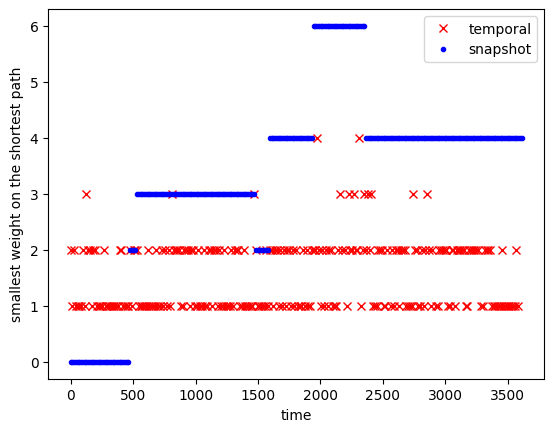

In [278]:
plt.plot(vv1['time'], weakest_link, 'rx', label='temporal')

plt.xlabel('time')
plt.ylabel('smallest weight on the shortest path')

plt.plot([x*14 for x in sv1['seq']], seakest_link, 'b.', label='snapshot')
plt.legend()

In [279]:
shortest_paths = snapsmoosh.get_shortest_paths(
                    sv0, sv1, 
                    weights='distance', 
                    output='epath'
                )

In [280]:
edge_index = {x:i for i,x in enumerate(list(dict.fromkeys(np.concatenate(shortest_paths))))}

In [281]:
ccc = plt.rcParams['axes.prop_cycle']
default_pal_c = ccc.by_key()['color']

cv_list = list(set(seakest_link))

Text(0, 0.5, 'identifier of edge')

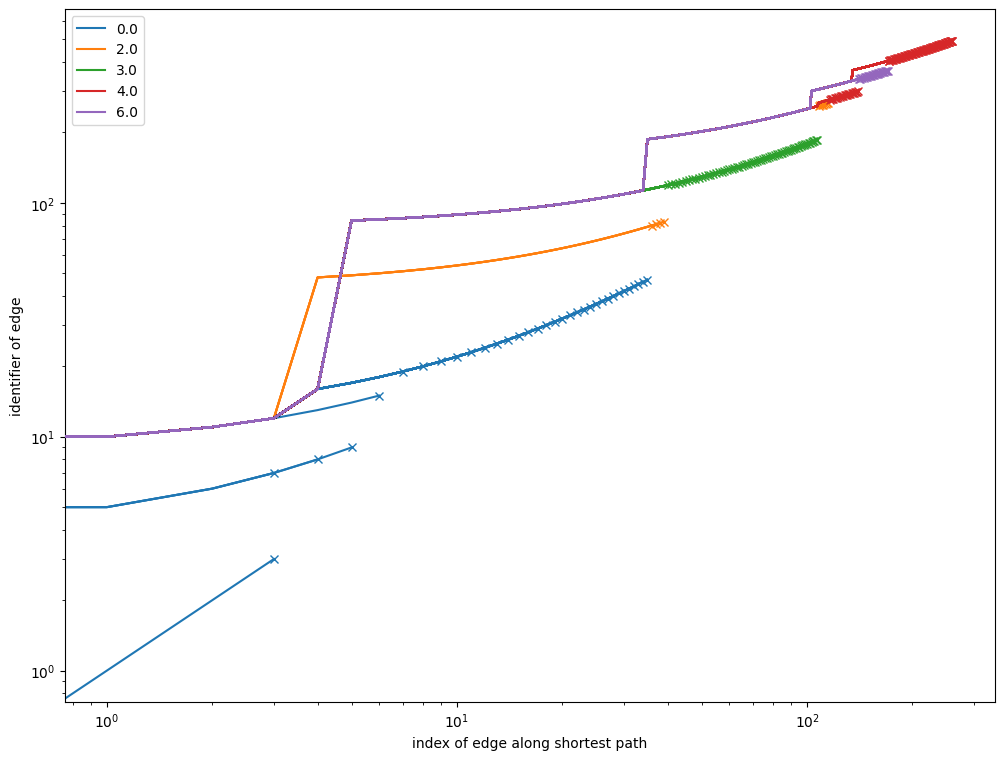

In [282]:
plt.figure(figsize=[12, 9])
for path in shortest_paths:
    cvi = int(min([ea if ea is not None else 10_000_000 
         for ea in snapsmoosh.es[path]['arrivals']]))
    cv = cv_list.index(cvi)    
    plt.plot(np.arange(len(path)), [edge_index[e] for e in path], 
             color=default_pal_c[cv], zorder=cvi)
    plt.plot(len(path)-1, edge_index[path[-1]], color=default_pal_c[cv], zorder=cvi, marker='x')

# plt.xlim([-5, 25])
# plt.ylim([-5, 100])
plt.yscale('log')
plt.xscale('log')

plt.legend(handles=[
    plt.Line2D([],[],color=c, label=i)
    for c,i in zip(default_pal_c,cv_list)
])

plt.xlabel('index of edge along shortest path')
plt.ylabel('identifier of edge')

In [287]:
def join_snapshots_expanded(graphs, join_distance=0):

    X = ig.Graph(directed=True)

    # generate the uniq locations
    uniq_locs = sorted(set(int(name) for g in graphs for name in g.vs['name']))
    n_locs = len(uniq_locs)

    # Add nodes from both graphs to the new graph, with 'loc' and 'seq' attributes
    for seq, _ in enumerate(graphs):
        # add all vertices
        for ntype in ('normal', 'home'):
            X.add_vertices(n_locs, attributes={'loc': uniq_locs, 'seq': seq, 'type': ntype})

    nnodes = X.vs.select(type_eq='normal')
    nnode_map = {(loc, seq): idx for loc, seq, idx in zip(nnodes['loc'], nnodes['seq'], nnodes.indices)}

    hnodes = X.vs.select(type_eq='home')
    hnode_map = {(loc, seq): idx for loc, seq, idx in zip(hnodes['loc'], hnodes['seq'], hnodes.indices)}

    # Add edges from the original graphs to the new graph
    standard_edges_ids = []
    standard_edges_distances = []
    go_home_edges = defaultdict(list)
    for seq, g in enumerate(graphs):

        for e in g.es:
            attr = e.attributes()
            src, tgt = int(attr['source']), int(attr['target'])
            if attr['weight'] > 0:
                if src != tgt:
                    standard_edges_ids.append((
                        nnode_map[(src,seq)], 
                        nnode_map[(tgt,seq)]
                    ))
                else: # change self loop into a next t distance
                    standard_edges_ids.append((
                        nnode_map[(src, seq)],
                        nnode_map[(src, seq+1)],
                    ))
                standard_edges_distances.append(
                        1./attr['weight']
                    )
            if attr['departures'] > 0:
                go_home_edges[
                    nnode_map[(src,seq)],
                    hnode_map[(src,seq)]
                ].append(attr['departures'])
            if attr['arrivals'] > 0:
                standard_edges_ids.append((
                    hnode_map[(src, seq-1)],
                    nnode_map[(tgt, seq)]
                ))
                standard_edges_distances.append(
                    1./attr['arrivals']
                )

    go_home_ids = go_home_edges.keys()
    go_home_distances = [1./sum(vs) for vs in go_home_edges.values()]

    X.add_edges(standard_edges_ids, attributes={'distance': standard_edges_distances})
    X.add_edges(go_home_ids, attributes={'distance': go_home_distances})

   
    seq_locs = [(hnode_map[loc,seq-1], hnode_map[loc, seq]) 
                for loc in uniq_locs 
                for seq in range(1,len(graphs))]
    X.add_edges(seq_locs, attributes={'distance': join_distance})

    return X

In [288]:
snapsq = join_snapshots_expanded([snapshots[si] for si in sorted(snapshots.keys())])

In [289]:
qv0 = snapsq.vs.select(loc_eq=ordering.hospitals[157], seq_eq=0, type_eq='normal')[0]
qv1 = snapsq.vs.select(loc_eq=ordering.hospitals[3], type_eq='normal')


In [298]:
qeakest_link = [max([ea for ea in snapsq.es[edges]['distance']]) if edges else np.nan
                for edges in snapsq.get_shortest_paths(
                    qv0, qv1, 
                    weights='distance', 
                    output='epath'
                )]

/tmp/ipykernel_84662/2953781847.py:2: RuntimeWarning: Couldn't reach some vertices. at src/paths/dijkstra.c:528
  for edges in snapsq.get_shortest_paths(


Text(0, 0.5, 'smallest weight on the shortest path')

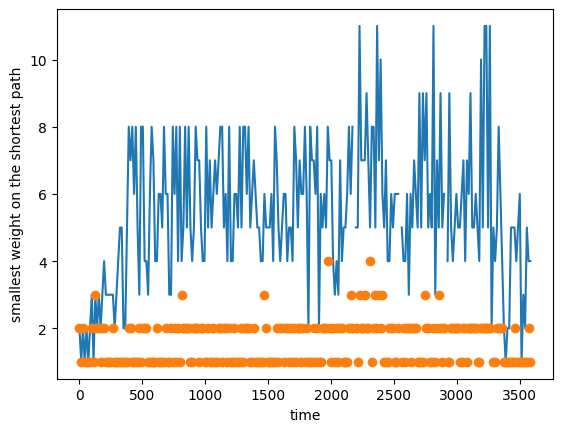

In [310]:
plt.plot(np.array(qv1['seq']) * 14, 1./np.array(qeakest_link), '-')
plt.plot(vv1['time'], weakest_link, 'o')

plt.xlabel('time')
plt.ylabel('smallest weight on the shortest path')

In [306]:
qhortest_paths = snapsq.get_shortest_paths(
                    qv0, qv1, 
                    weights='distance', 
                )

/tmp/ipykernel_84662/2155671722.py:1: RuntimeWarning: Couldn't reach some vertices. at src/paths/dijkstra.c:528
  qhortest_paths = snapsq.get_shortest_paths(


In [307]:
qhortest_paths[0]

[157, 247, 212, 206, 3]

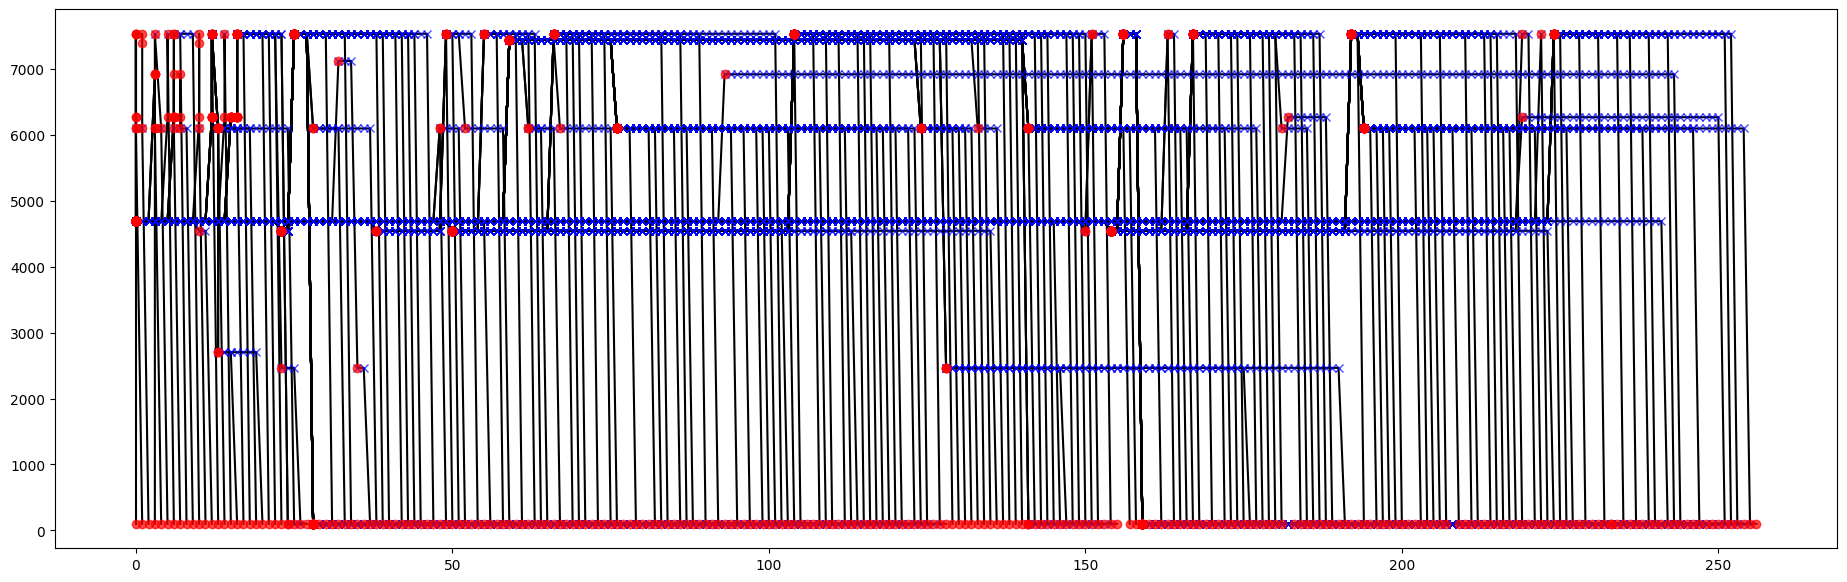

In [309]:
plt.figure(figsize=[23, 7])
for vnds in qhortest_paths:
    vpath = snapsq.vs[vnds]
    vpnorm = vpath.select(type_eq='normal')
    vphome = vpath.select(type_eq='home')
    plt.plot(vpath['seq'], vpath['loc'], 'k', zorder=0)
    plt.plot(vpnorm['seq'], vpnorm['loc'], 'ro', zorder=2, alpha=0.7)
    plt.plot(vphome['seq'], vphome['loc'], 'bx', zorder=1, alpha=0.7)
# plt.xscale('log')